In [40]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = '/content/drive/MyDrive/ML_final_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

DATAPATH = f'{FOLDERNAME}/data/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# !pip install numpy==1.26.4 --force-reinstall -q
# !pip install mlflow==2.15.1 -q

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datetime import datetime, timedelta

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
#import optuna
import joblib
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.pipeline import Pipeline

In [43]:
# Install packages
!pip install dagshub mlflow -q

# Import
import dagshub
import mlflow

# Simple initialization (like in the fraud detection notebook)

dagshub.init(repo_owner='kechik21', repo_name='ML_Final_Project', mlflow=True)

# Set tracking URI to DagsHub (and DON'T override it later!)
mlflow.set_tracking_uri('https://dagshub.com/kechik21/ML_Final_Project.mlflow')

# Set experiment
try:
    experiment_id = mlflow.create_experiment("XGBoost_Training")
    print(f"Created new experiment: XGBoost_Training")
except mlflow.exceptions.MlflowException:
    experiment = mlflow.get_experiment_by_name("XGBoost_Training")
    experiment_id = experiment.experiment_id
    print(f"Using existing experiment: XGBoost_Training")

mlflow.set_experiment("XGBoost_Training")

print("✅ MLflow setup complete!")
print("🔗 Your experiments will be visible at:")
print("   https://dagshub.com/kechik21/ML_Final_Project")

Initialized MLflow to track repo "kechik21/ML_Final_Project"

Repository kechik21/ML_Final_Project initialized!

Using existing experiment: XGBoost_Training
✅ MLflow setup complete!
🔗 Your experiments will be visible at:
   https://dagshub.com/kechik21/ML_Final_Project


# **MLflow Setup**

In [44]:
#mlflow.set_tracking_uri("file:///content/drive/MyDrive/ML_final_project/mlruns")
#experiment_name = "XGBoost_Training"

# Create or get experiment
#try:
 #   experiment_id = mlflow.create_experiment(experiment_name)
 #   print(f"Created new experiment: {experiment_name}")
#except mlflow.exceptions.MlflowException:
 #   experiment = mlflow.get_experiment_by_name(experiment_name)
 #   experiment_id = experiment.experiment_id
 #   print(f"Using existing experiment: {experiment_name}")

#mlflow.set_experiment(experiment_name)
#print(f"Experiment ID: {experiment_id}")

**Initial Data**

In [45]:
train_df = pd.read_csv(DATAPATH + 'train.csv')
test_df = pd.read_csv(DATAPATH + 'test.csv')
features_df = pd.read_csv(DATAPATH + 'features.csv')
stores_df = pd.read_csv(DATAPATH + 'stores.csv')


In [46]:
print(f"Train Shape : {train_df.shape}")
print(f"Train Shape : {test_df.shape}")
print(f"Train Shape : {features_df.shape}")
print(f"Train Shape : {stores_df.shape}")

Train Shape : (421570, 5)
Train Shape : (115064, 4)
Train Shape : (8190, 12)
Train Shape : (45, 3)


დავლოგავ ჩემი საწყისი დეითას ზომებს, რათა შემდეგ ქლინინგის შედეგად მიღებულს შევადარო

In [47]:
with mlflow.start_run(run_name= "XGBoost_Data_Loading") as run:
  mlflow.log_metric("initial_train_rows", train_df.shape[0])
  mlflow.log_metric("initial_train_cols", train_df.shape[1])
  mlflow.log_metric("initial_test_rows", test_df.shape[0])
  mlflow.log_metric("initial_test_cols", test_df.shape[1])


2025/08/03 08:03:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost_Data_Loading at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0/runs/8381125781aa479ba6e233c6b859e520.
2025/08/03 08:03:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0.


# **Cleaning**

In [48]:
from datetime import datetime, timedelta
#იმისთვის, რომ ბევრად მარტივი გახდეს მუშაობა და
#ადვილად შევძლოთ დროსთან კავშირი ,გადავიყვანოთ
#object ---> datetime

def object_to_datetime(input, col = 'Data', curr_part=''):
  before_type = input[col].dtype
  input[col]=pd.to_datetime(input[col])
  after_type = input[col].dtype
  print(f"Converting data types for {curr_part}" )
  print(f"Before - {before_type}")
  print(f"After - {after_type}")
  print(" ")
  return input

train_df = object_to_datetime(train_df, col='Date', curr_part='Train data')
test_df = object_to_datetime(test_df, col='Date', curr_part='Test data')
features_df = object_to_datetime(features_df, col='Date', curr_part='Features data')


Converting data types for Train data
Before - object
After - datetime64[ns]
 
Converting data types for Test data
Before - object
After - datetime64[ns]
 
Converting data types for Features data
Before - object
After - datetime64[ns]
 


In [49]:
#დამატებითი დეითას მერჯინგი ტესტთან და ტრეინთან
train_merged = train_df.merge(stores_df, on='Store', how='left')
test_merged = test_df.merge(stores_df, on='Store', how='left')

#features-ის დამატება
train_merged = train_merged.merge(features_df, on=['Store', 'Date'], how='left')
test_merged = test_merged.merge(features_df, on=['Store', 'Date'], how='left')

In [50]:
def group_columns_by_dtype(df):
    data_types = df.dtypes.unique()
    for dtype in data_types:
        cols = df.select_dtypes(include=[dtype]).columns.tolist()
        print(f"\n{dtype} columns:")
        for col in cols:
            print(f" * {col}")


In [51]:
group_columns_by_dtype(train_merged)


int64 columns:
 * Store
 * Dept
 * Size

datetime64[ns] columns:
 * Date

float64 columns:
 * Weekly_Sales
 * Temperature
 * Fuel_Price
 * MarkDown1
 * MarkDown2
 * MarkDown3
 * MarkDown4
 * MarkDown5
 * CPI
 * Unemployment

bool columns:
 * IsHoliday_x
 * IsHoliday_y

object columns:
 * Type


In [52]:
def print_columns_info():
    print("Feature Columns:")
    print("   ", features_df.columns.tolist(), "\n")

    print("Store Columns:")
    print("   ", stores_df.columns.tolist(), "\n")

    print("Train Columns:")
    print("   Before merging:", train_df.columns.tolist())
    print("   After  merging:", train_merged.columns.tolist(), "\n")

    print("Test Columns:")
    print("   Before merging:", test_df.columns.tolist())
    print("   After  merging:", test_merged.columns.tolist(), "\n")


print_columns_info()


Feature Columns:
    ['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday'] 

Store Columns:
    ['Store', 'Type', 'Size'] 

Train Columns:
   Before merging: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']
   After  merging: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y'] 

Test Columns:
   Before merging: ['Store', 'Dept', 'Date', 'IsHoliday']
   After  merging: ['Store', 'Dept', 'Date', 'IsHoliday_x', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y'] 



გაგვიჩნდა პატარა პრობლემა, მერჯინგის დროს გაჩნდა IsHoliday_x & IsHoliday_y , ამიტომაც გავარკვიოთ რომლის დატოვე სჯობს

In [53]:
same_cols = (train_merged['IsHoliday_x'] == train_merged['IsHoliday_y']).all()
print("Are they the same? ", same_cols)


Are they the same?  True


In [54]:
train_merged['IsHoliday'] = train_merged['IsHoliday_y'].fillna(train_merged['IsHoliday_x'])
test_merged['IsHoliday'] = test_merged['IsHoliday_y'].fillna(test_merged['IsHoliday_x'])

train_merged = train_merged.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1)
test_merged = test_merged.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1)

რადგანაც Weekly Sales ზოგიერთგან უარყოფითი გვაქვს, მოვიშოროთ

In [55]:
init_rows = len(train_merged)
train_merged = train_merged[train_merged['Weekly_Sales'] >=0 ]
removed_ones = init_rows - len(train_merged)
print(f"Removed negative values are {removed_ones}")

Removed negative values are 1285


In [56]:
with mlflow.start_run(run_name="XGBoost_Cleaning") as run:
  mlflow.log_metric("negative_saled_removed",removed_ones)


2025/08/03 08:03:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost_Cleaning at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0/runs/3609be633d154aa694b8bc5ecc73eeff.
2025/08/03 08:03:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0.


**Finding Missing Values**

In [57]:
def check_missing(input, name="DataFrame"):
    missing_amount = input.isnull().sum()
    really_missing = missing_amount[missing_amount > 0]

    if not really_missing.empty:
        print(f" Missing values in {name}:")
        print(really_missing)
        return really_missing.to_dict()
    else:
        print(f"No missing values")
        return {}

In [58]:
with mlflow.start_run(run_name="XGBoost_Missing_values") as run:
   train_missing = check_missing(train_merged, "Train Merged")
   test_missing = check_missing(test_merged, "Test Merged")

   #დავლოგოთ მისინგები
   for col, count in train_missing.items():
        mlflow.log_metric(f"train_missing_{col}", count)
   for col, count in test_missing.items():
        mlflow.log_metric(f"test_missing_{col}", count)

 Missing values in Train Merged:
MarkDown1    270085
MarkDown2    309367
MarkDown3    283618
MarkDown4    285750
MarkDown5    269337
dtype: int64
 Missing values in Test Merged:
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
CPI             38162
Unemployment    38162
dtype: int64


2025/08/03 08:04:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost_Missing_values at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0/runs/da16ebed85bb401fb6a7e12e86d0b2ae.
2025/08/03 08:04:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0.


In [59]:
check_missing(train_merged, "Train Merged")
check_missing(test_merged, "Test Merged")

 Missing values in Train Merged:
MarkDown1    270085
MarkDown2    309367
MarkDown3    283618
MarkDown4    285750
MarkDown5    269337
dtype: int64
 Missing values in Test Merged:
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
CPI             38162
Unemployment    38162
dtype: int64


{'MarkDown1': 149,
 'MarkDown2': 28627,
 'MarkDown3': 9829,
 'MarkDown4': 12888,
 'CPI': 38162,
 'Unemployment': 38162}

In [60]:
num_cols = ['CPI','Fuel_Price','Unemployment','Temperature']

In [61]:
def fill_numericals(num_cols,train_merged,test_merged):
  for col in num_cols:
    if col in train_merged.columns:
        train_missing = train_merged[col].isnull().sum()
        if train_missing > 0:
            print(f"Filling {train_missing} missing values in {col} (train)")
            train_merged[col] = train_merged.groupby('Store')[col].ffill()
            train_merged[col] = train_merged[col].fillna(train_merged[col].median())


        test_missing = test_merged[col].isnull().sum()
        if test_missing > 0:
            print(f"Filling {test_missing} missing values in {col} (test)")
            test_merged[col] = test_merged.groupby('Store')[col].ffill()
            test_merged[col] = test_merged[col].fillna(test_merged[col].median())

In [62]:
fill_numericals(num_cols,train_merged,test_merged)

Filling 38162 missing values in CPI (test)
Filling 38162 missing values in Unemployment (test)


რადგანაც Mark Downs გვაქვს მხოლოდ missing data-თი, შევავსოთ ნულებით

In [63]:
markdowns = [col for col in train_merged.columns if 'MarkDown' in col]
for col in markdowns:
    train_merged[col] = train_merged[col].fillna(0)
    test_merged[col] = test_merged[col].fillna(0)

ყოველი შემთხვევისთვის, isHoliday-ც გავითვალისწინოთ

In [64]:
train_merged['IsHoliday'] = train_merged['IsHoliday'].fillna(False)
test_merged['IsHoliday'] = test_merged['IsHoliday'].fillna(False)

Markdown-ების ნაწილი, რომელიც შედარებით ცუდია, კერძოს 1/3/5 მოვიშოროთ

In [65]:
removed_cols = ['MarkDown1','MarkDown3','MarkDown5']
mlflow.log_param("removed_cols",removed_cols)

['MarkDown1', 'MarkDown3', 'MarkDown5']

In [66]:
train_merged = train_merged.drop('MarkDown1', axis=1)
train_merged = train_merged.drop('MarkDown3', axis=1)
train_merged = train_merged.drop('MarkDown5', axis=1)
test_merged = test_merged.drop('MarkDown1', axis=1)
test_merged = test_merged.drop('MarkDown3', axis=1)
test_merged = test_merged.drop('MarkDown5', axis=1)

# **Feature Engineering**

In [67]:
def additional_time_feat(input):
  input = input.copy()
  input['Day'] = input['Date'].dt.day.astype('int64')
  input['Week'] = input['Date'].dt.isocalendar().week.astype('int64')
  input['Month'] = input['Date'].dt.month.astype('int64')
  input['Year'] = input['Date'].dt.year.astype('int64')
  const_month = 2 * np.pi * input['Month']
  const_week = 2 * np.pi * input['Week']
  input['Month_sin'] = np.sin( const_month/ 12).astype('float64')
  input['Month_cos'] = np.cos(const_month / 12).astype('float64')
  input['Week_sin'] = np.sin( const_week/ 52).astype('float64')
  input['Week_cos'] = np.cos(const_week/ 52).astype('float64')

  return input

In [68]:
def additional_cat_feat(input):
  input= input.copy()
  label_enc_type = LabelEncoder()
  input['Type_le'] = label_enc_type.fit_transform(input['Type'])
  return input, label_enc_type

In [69]:
def additional_month_feat_train(input, col='Weekly_Sales'):
    input = input.copy()
    input = input.reset_index(drop=True)
    input = input.sort_values(['Store','Dept','Date'])
    print(f"Additional features are being added for {col}")

    my_w = [4, 8, 12]

    for w in my_w:
        print(f"Adding {w} week rolling mean features")
        added_mn = []
        for (store, dept), group in input.groupby(['Store', 'Dept']):
            group = group.sort_values('Date').reset_index(drop=True)
            month_mean = group[col].rolling(w, min_periods=1).mean()
            added_mn.extend(month_mean.values)
        input = input.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)
        input[f'{col}_month_mean_{w}'] = added_mn
        print(f"Added column: {col}_month_mean_{w}")
    print("All addition is done")
    return input

In [70]:
def additional_month_feat_test(train_data, test_input, col='Weekly_Sales'):
    test_input = test_input.copy()
    print(f"Adding rolling features to test data depending on {col}")
    month_cols = [c for c in train_data.columns if f'{col}_month_mean_' in c]
    for month_col in month_cols:
        print(f"Adding {month_col} to test data")
        store_dept_avg = train_data.groupby(['Store', 'Dept'])[month_col].mean().reset_index()
        store_dept_avg.columns = ['Store', 'Dept', month_col]
        test_input = test_input.merge(store_dept_avg, on=['Store', 'Dept'], how='left')
        overall_avg = train_data[month_col].mean()
        test_input[month_col] = test_input[month_col].fillna(overall_avg)

    print("All rolling features are complete")
    return test_input

In [71]:
mlflow.end_run()

with mlflow.start_run(run_name="XGBoost_Feature_Engineering") as run:
  train_merged= additional_time_feat(train_merged)
  test_merged = additional_time_feat(test_merged)
  train_merged,le_1= additional_cat_feat(train_merged)
  test_merged['Type_le'] = le_1.transform(test_merged['Type'])
  train_merged = additional_month_feat_train(train_merged, col='Weekly_Sales')
  test_merged = additional_month_feat_test(train_merged, test_merged, col='Weekly_Sales')

  mlflow.log_param("time_features_added", ["Day", "Week", "Month", "Year", "Month_sin", "Month_cos", "Week_sin", "Week_cos"])
  mlflow.log_param("rolling_windows", [4, 8, 12])
  mlflow.log_param("categorical_encoding", "LabelEncoder")


  print(f"Final train shape is : {train_merged.shape}")
  print(f"Final test shape is : {test_merged.shape}")

  mlflow.log_metric("final_train_features", train_merged.shape[1])
  mlflow.log_metric("final_test_features", test_merged.shape[1])

2025/08/03 08:04:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run gaudy-penguin-210 at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0/runs/cca35abe9e1f4940b1300dcbe1765409.
2025/08/03 08:04:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0.


Additional features are being added for Weekly_Sales
Adding 4 week rolling mean features
Added column: Weekly_Sales_month_mean_4
Adding 8 week rolling mean features
Added column: Weekly_Sales_month_mean_8
Adding 12 week rolling mean features
Added column: Weekly_Sales_month_mean_12
All addition is done
Adding rolling features to test data depending on Weekly_Sales
Adding Weekly_Sales_month_mean_4 to test data
Adding Weekly_Sales_month_mean_8 to test data
Adding Weekly_Sales_month_mean_12 to test data
All rolling features are complete
Final train shape is : (420285, 25)
Final test shape is : (115064, 24)


2025/08/03 08:04:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost_Feature_Engineering at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0/runs/3fb6bf75651c467eaf1305164218f96a.
2025/08/03 08:04:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0.


# **Pipeline Creation**

In [72]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.pipeline import Pipeline

In [73]:
from sklearn.base import BaseEstimator, TransformerMixin

class WalmartDataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoder = None
        self.train_data_for_rolling = None

    def fit(self, X, y=None):
        self.label_encoder = le_1
        self.train_data_for_rolling = train_merged

        return self

    def transform(self, X):
        X_processed = X.copy()
        X_processed = X_processed.merge(stores_df, on='Store', how='left')
        X_processed = X_processed.merge(features_df, on=['Store', 'Date'], how='left')


        if 'IsHoliday_x' in X_processed.columns and 'IsHoliday_y' in X_processed.columns:
            X_processed['IsHoliday'] = X_processed['IsHoliday_y'].fillna(X_processed['IsHoliday_x'])
            X_processed = X_processed.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1)


        X_processed = object_to_datetime(X_processed, col='Date', curr_part='Pipeline transform')


        num_cols = ['CPI', 'Fuel_Price', 'Unemployment', 'Temperature']
        fill_numericals(num_cols, X_processed, X_processed)  # Just pass same df twice


        markdowns = [col for col in X_processed.columns if 'MarkDown' in col]
        for col in markdowns:
            X_processed[col] = X_processed[col].fillna(0)
        X_processed['IsHoliday'] = X_processed['IsHoliday'].fillna(False)
        removed_cols = ['MarkDown1', 'MarkDown3', 'MarkDown5']
        X_processed = X_processed.drop([col for col in removed_cols if col in X_processed.columns], axis=1)
        X_processed = additional_time_feat(X_processed)
        X_processed['Type_le'] = self.label_encoder.transform(X_processed['Type'])
        X_processed = additional_month_feat_test(self.train_data_for_rolling, X_processed, col='Weekly_Sales')
        cols_to_remove = ['Date', 'Type']
        if 'Weekly_Sales' in X_processed.columns:
            cols_to_remove.append('Weekly_Sales')
        X_processed = X_processed.drop([col for col in cols_to_remove if col in X_processed.columns], axis=1)

        return X_processed

# **Cross Validation**

In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [75]:
def run_cross_validation(X_train, y_train):
    """Complete your cross validation function"""

    with mlflow.start_run(run_name="XGBoost_Cross_Validation") as run:
        tscv = TimeSeriesSplit(n_splits=5)
        cv_scores = []
        last_X_val = None
        last_y_val = None

        base_params = {
            'objective': 'reg:squarederror',
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 1000,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
            'n_jobs': -1
        }
        for param, value in base_params.items():
            mlflow.log_param(f"cv_{param}", value)

        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
            print(f"Working on fold {fold + 1}/5")

            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model = xgb.XGBRegressor(**base_params)
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)

            y_pred = model.predict(X_val)
            mae = mean_absolute_error(y_val, y_pred)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            r2 = r2_score(y_val, y_pred)

            cv_scores.append({'fold': fold, 'mae': mae, 'rmse': rmse, 'r2': r2})

            # Log metrics
            mlflow.log_metric(f"fold_{fold}_mae", mae)
            mlflow.log_metric(f"fold_{fold}_rmse", rmse)
            mlflow.log_metric(f"fold_{fold}_r2", r2)

            print(f"  MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")

            last_X_val = X_val
            last_y_val = y_val

        avg_mae = np.mean([score['mae'] for score in cv_scores])
        avg_rmse = np.mean([score['rmse'] for score in cv_scores])
        avg_r2 = np.mean([score['r2'] for score in cv_scores])

        mlflow.log_metric("cv_avg_mae", avg_mae)
        mlflow.log_metric("cv_avg_rmse", avg_rmse)
        mlflow.log_metric("cv_avg_r2", avg_r2)

        print(f"\\nCross Validation Results:")
        print(f"Average MAE: {avg_mae:.2f}")
        print(f"Average RMSE: {avg_rmse:.2f}")
        print(f"Average R2: {avg_r2:.4f}")

        return cv_scores, last_X_val, last_y_val

# **Training**

In [76]:
def run_final_training(X_train, y_train):
    """Complete your final training function"""

    with mlflow.start_run(run_name="XGBoost_Final_Training") as run:

        final_params = {
            'objective': 'reg:squarederror',
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 1000,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
            'n_jobs': -1
        }


        for param, value in final_params.items():
            mlflow.log_param(param, value)


        final_model = xgb.XGBRegressor(**final_params)
        final_model.fit(X_train, y_train)


        pipeline = Pipeline([
            ('preprocessor', WalmartDataPreprocessor()),
            ('model', xgb.XGBRegressor(**final_params))
        ])
        original_X = train_df.drop('Weekly_Sales', axis=1)
        original_y = train_df['Weekly_Sales']
        pipeline.fit(original_X, original_y)
        mlflow.sklearn.log_model(
            pipeline,
            "xgboost_pipeline",
            registered_model_name="walmart_xgboost_pipeline"
        )

        mlflow.xgboost.log_model(
            final_model,
            "xgboost_model",
            registered_model_name="walmart_xgboost_model"
        )
        #mlflow.sklearn.log_model(pipeline, "xgboost_pipeline")
        #mlflow.xgboost.log_model(final_model, "xgboost_model")


        train_pred = final_model.predict(X_train)
        mae = mean_absolute_error(y_train, train_pred)
        rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        r2 = r2_score(y_train, train_pred)
        mlflow.log_metric("final_mae", mae)
        mlflow.log_metric("final_rmse", rmse)
        mlflow.log_metric("final_r2", r2)

        print(f"Final model metrics:")
        print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")

        return pipeline, final_model

# **Main Execution**

In [77]:
feature_cols = [col for col in train_merged.columns if col not in ['Weekly_Sales', 'Date', 'Type']]
removed_cols = ['MarkDown1', 'MarkDown3', 'MarkDown5']
feature_cols = [col for col in feature_cols if col not in removed_cols]

X_train = train_merged[feature_cols].copy()
y_train = train_merged['Weekly_Sales'].copy()

print(f"\\nTraining with {len(feature_cols)} features using your processed data")
print(f"Training data shape: {X_train.shape}")

print("RUNNING CROSS VALIDATION")

cv_scores, X_val, y_val = run_cross_validation(X_train, y_train)
print("TRAINING FINAL MODEL")
pipeline, model = run_final_training(X_train, y_train)

print("GENERATING PREDICTIONS")


test_feature_cols = [col for col in feature_cols if col in test_merged.columns]
X_test_processed = test_merged[test_feature_cols].copy()
for col in feature_cols:
    if col not in X_test_processed.columns:
        print(f"Adding missing column {col} with default value 0")
        X_test_processed[col] = 0
X_test_processed = X_test_processed[feature_cols]
test_predictions = model.predict(X_test_processed)

print(f"Generated {len(test_predictions)} test predictions")
print(" XGBoost model complete with pipeline!")

\nTraining with 22 features using your processed data
Training data shape: (420285, 22)
RUNNING CROSS VALIDATION
Working on fold 1/5
  MAE: 1835.92, RMSE: 5392.02, R2: 0.9600
Working on fold 2/5
  MAE: 1392.25, RMSE: 3086.51, R2: 0.9798
Working on fold 3/5
  MAE: 1417.63, RMSE: 3028.43, R2: 0.9810
Working on fold 4/5
  MAE: 1215.09, RMSE: 2786.48, R2: 0.9771
Working on fold 5/5
  MAE: 983.30, RMSE: 2455.81, R2: 0.9839
\nCross Validation Results:
Average MAE: 1368.84
Average RMSE: 3349.85
Average R2: 0.9763


2025/08/03 08:05:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost_Cross_Validation at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0/runs/706915f15d7b4660b95c6a8b544344a5.
2025/08/03 08:05:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0.


TRAINING FINAL MODEL
Converting data types for Pipeline transform
Before - datetime64[ns]
After - datetime64[ns]
 
Adding rolling features to test data depending on Weekly_Sales
Adding Weekly_Sales_month_mean_4 to test data
Adding Weekly_Sales_month_mean_8 to test data
Adding Weekly_Sales_month_mean_12 to test data
All rolling features are complete


/usr/local/lib/python3.11/dist-packages/_distutils_hack/__init__.py:16: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Registered model 'walmart_xgboost_pipeline' already exists. Creating a new version of this model...
2025/08/03 08:05:51 INFO mlflow.store.model_registry.abstract_s

Final model metrics:
MAE: 940.17, RMSE: 1715.17, R2: 0.9943


2025/08/03 08:06:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost_Final_Training at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0/runs/be891eb078e7430791a3d2deaa887885.
2025/08/03 08:06:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0.


GENERATING PREDICTIONS
Generated 115064 test predictions
 XGBoost model complete with pipeline!


# **Submission File**

In [78]:
with mlflow.start_run(run_name="XGBoost_Submission_Generation") as run:
    print("\\n" + "="*50)
    print("CREATING SUBMISSION FILE")
    print("="*50)
    test_submission = test_merged[['Store', 'Dept', 'Date']].copy()
    test_submission['Weekly_Sales'] = test_predictions
    test_submission['Id'] = (test_submission['Store'].astype(str) + '_' +
                           test_submission['Dept'].astype(str) + '_' +
                           test_submission['Date'].dt.strftime('%Y-%m-%d'))

    submission = test_submission[['Id', 'Weekly_Sales']].copy()
    submission_path = f"{FOLDERNAME}/xgboost_submission.csv"
    submission.to_csv(submission_path, index=False)


    mlflow.log_artifact(submission_path)
    mlflow.log_metric("submission_rows", len(submission))

    print(f"Submission saved to: {submission_path}")
    print(f"Submission shape: {submission.shape}")
    print("\\nFirst 10 rows of submission:")
    print(submission.head(10))

    print(" XGBOOST EXPERIMENT COMPLETED SUCCESSFULLY!")
    print(" All MLflow runs logged")
    print(" Model registered in Model Registry")
    print(" Pipeline ready for deployment")
    print(" Submission file generated")

\n==================================================
CREATING SUBMISSION FILE
Submission saved to: /content/drive/MyDrive/ML_final_project/xgboost_submission.csv
Submission shape: (115064, 2)
\nFirst 10 rows of submission:
               Id  Weekly_Sales
0  1_1_2012-11-02  21985.888672
1  1_1_2012-11-09  16865.597656
2  1_1_2012-11-16  16319.472656
3  1_1_2012-11-23  19903.292969
4  1_1_2012-11-30  23269.095703
5  1_1_2012-12-07  28609.849609
6  1_1_2012-12-14  32376.074219
7  1_1_2012-12-21  32428.712891
8  1_1_2012-12-28  16986.541016
9  1_1_2013-01-04  14688.860352
 XGBOOST EXPERIMENT COMPLETED SUCCESSFULLY!
 All MLflow runs logged
 Model registered in Model Registry
 Pipeline ready for deployment
 Submission file generated


2025/08/03 08:06:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost_Submission_Generation at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0/runs/bc5a0c782557482c88263395a42e66cf.
2025/08/03 08:06:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0.


In [80]:
# XGBoost Model Visualization Code
# Add this to your Jupyter notebook after model training

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def plot_cross_validation_results(cv_scores):
    """Plot cross-validation results"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Extract metrics
    folds = [score['fold'] for score in cv_scores]
    mae_scores = [score['mae'] for score in cv_scores]
    rmse_scores = [score['rmse'] for score in cv_scores]
    r2_scores = [score['r2'] for score in cv_scores]

    # MAE across folds
    axes[0].bar(folds, mae_scores, alpha=0.7, color='skyblue')
    axes[0].set_title('MAE Across CV Folds')
    axes[0].set_xlabel('Fold')
    axes[0].set_ylabel('MAE')
    axes[0].axhline(y=np.mean(mae_scores), color='red', linestyle='--',
                    label=f'Mean: {np.mean(mae_scores):.2f}')
    axes[0].legend()

    # RMSE across folds
    axes[1].bar(folds, rmse_scores, alpha=0.7, color='lightgreen')
    axes[1].set_title('RMSE Across CV Folds')
    axes[1].set_xlabel('Fold')
    axes[1].set_ylabel('RMSE')
    axes[1].axhline(y=np.mean(rmse_scores), color='red', linestyle='--',
                    label=f'Mean: {np.mean(rmse_scores):.2f}')
    axes[1].legend()

    # R² across folds
    axes[2].bar(folds, r2_scores, alpha=0.7, color='coral')
    axes[2].set_title('R² Across CV Folds')
    axes[2].set_xlabel('Fold')
    axes[2].set_ylabel('R²')
    axes[2].axhline(y=np.mean(r2_scores), color='red', linestyle='--',
                    label=f'Mean: {np.mean(r2_scores):.4f}')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names, top_n=15):
    """Plot feature importance"""
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance, y='feature', x='importance')
    plt.title(f'Top {top_n} Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    return feature_importance

def plot_learning_curves(model, X_train, y_train, X_val=None, y_val=None):
    """Plot learning curves during training"""
    if hasattr(model, 'evals_result_'):
        results = model.evals_result_
        epochs = len(results['validation_0']['rmse'])
        x_axis = range(0, epochs)

        plt.figure(figsize=(10, 6))
        plt.plot(x_axis, results['validation_0']['rmse'], label='Train RMSE')
        if 'validation_1' in results:
            plt.plot(x_axis, results['validation_1']['rmse'], label='Validation RMSE')

        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title('XGBoost Learning Curves')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("Model doesn't have evals_result_. Train with eval_set to see learning curves.")

def plot_residuals(y_true, y_pred):
    """Plot residual analysis"""
    residuals = y_true - y_pred

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Residuals vs Predicted
    axes[0].scatter(y_pred, residuals, alpha=0.6)
    axes[0].axhline(y=0, color='red', linestyle='--')
    axes[0].set_xlabel('Predicted Values')
    axes[0].set_ylabel('Residuals')
    axes[0].set_title('Residuals vs Predicted')

    # QQ plot
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1])
    axes[1].set_title('Q-Q Plot of Residuals')

    # Histogram of residuals
    axes[2].hist(residuals, bins=50, alpha=0.7, density=True)
    axes[2].set_xlabel('Residuals')
    axes[2].set_ylabel('Density')
    axes[2].set_title('Distribution of Residuals')

    # Add normal curve
    mu, sigma = stats.norm.fit(residuals)
    x = np.linspace(residuals.min(), residuals.max(), 100)
    axes[2].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

def plot_actual_vs_predicted(y_true, y_pred, sample_size=1000):
    """Plot actual vs predicted values"""
    # Sample for better visualization if dataset is large
    if len(y_true) > sample_size:
        indices = np.random.choice(len(y_true), sample_size, replace=False)
        y_true_sample = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_pred_sample = y_pred[indices]
    else:
        y_true_sample, y_pred_sample = y_true, y_pred

    plt.figure(figsize=(10, 8))
    plt.scatter(y_true_sample, y_pred_sample, alpha=0.6)

    # Perfect prediction line
    min_val = min(min(y_true_sample), min(y_pred_sample))
    max_val = max(max(y_true_sample), max(y_pred_sample))
    plt.plot([min_val, max_val], [min_val, max_val], 'red', linestyle='--', linewidth=2)

    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')

    # Add metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    plt.text(0.05, 0.95, f'MAE: {mae:.2f}\nRMSE: {rmse:.2f}',
             transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             verticalalignment='top')

    plt.grid(True, alpha=0.3)
    plt.show()

def plot_monthly_trends(data, date_col='Date', sales_col='Weekly_Sales'):
    """Plot monthly sales trends"""
    data_copy = data.copy()
    data_copy['Month'] = pd.to_datetime(data_copy[date_col]).dt.month
    data_copy['Year'] = pd.to_datetime(data_copy[date_col]).dt.year

    monthly_stats = data_copy.groupby('Month')[sales_col].agg(['mean', 'std']).reset_index()

    plt.figure(figsize=(12, 6))
    plt.plot(monthly_stats['Month'], monthly_stats['mean'], marker='o', linewidth=2, markersize=8)
    plt.fill_between(monthly_stats['Month'],
                     monthly_stats['mean'] - monthly_stats['std'],
                     monthly_stats['mean'] + monthly_stats['std'],
                     alpha=0.3)

    plt.xlabel('Month')
    plt.ylabel('Average Weekly Sales')
    plt.title('Monthly Sales Trends with Standard Deviation')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_store_performance(data, store_col='Store', sales_col='Weekly_Sales', top_n=10):
    """Plot top performing stores"""
    store_performance = data.groupby(store_col)[sales_col].agg(['mean', 'sum']).reset_index()
    store_performance = store_performance.sort_values('mean', ascending=False).head(top_n)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Average sales per store
    sns.barplot(data=store_performance, x=store_col, y='mean', ax=axes[0])
    axes[0].set_title(f'Top {top_n} Stores by Average Sales')
    axes[0].set_xlabel('Store')
    axes[0].set_ylabel('Average Weekly Sales')
    axes[0].tick_params(axis='x', rotation=45)

    # Total sales per store
    sns.barplot(data=store_performance, x=store_col, y='sum', ax=axes[1])
    axes[1].set_title(f'Top {top_n} Stores by Total Sales')
    axes[1].set_xlabel('Store')
    axes[1].set_ylabel('Total Weekly Sales')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return store_performance

def plot_holiday_impact(data, holiday_col='IsHoliday', sales_col='Weekly_Sales'):
    """Plot holiday vs non-holiday sales impact"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Box plot
    sns.boxplot(data=data, x=holiday_col, y=sales_col, ax=axes[0])
    axes[0].set_title('Sales Distribution: Holiday vs Regular Days')
    axes[0].set_xlabel('Is Holiday')
    axes[0].set_ylabel('Weekly Sales')

    # Average comparison
    holiday_avg = data.groupby(holiday_col)[sales_col].mean()
    holiday_avg.plot(kind='bar', ax=axes[1], color=['skyblue', 'orange'])
    axes[1].set_title('Average Sales: Holiday vs Regular Days')
    axes[1].set_xlabel('Is Holiday')
    axes[1].set_ylabel('Average Weekly Sales')
    axes[1].tick_params(axis='x', rotation=0)

    # Count of days
    holiday_count = data[holiday_col].value_counts()
    axes[2].pie(holiday_count.values, labels=['Regular Days', 'Holidays'], autopct='%1.1f%%',
                colors=['lightblue', 'orange'])
    axes[2].set_title('Distribution of Holiday vs Regular Days')

    plt.tight_layout()
    plt.show()

    # Print statistics
    regular_avg = data[data[holiday_col] == False][sales_col].mean()
    holiday_avg = data[data[holiday_col] == True][sales_col].mean()
    lift = ((holiday_avg - regular_avg) / regular_avg) * 100

    print(f"Regular Days Average Sales: ${regular_avg:,.2f}")
    print(f"Holiday Average Sales: ${holiday_avg:,.2f}")
    print(f"Holiday Lift: {lift:.1f}%")

def plot_department_analysis(data, dept_col='Dept', sales_col='Weekly_Sales', top_n=15):
    """Analyze department performance"""
    dept_stats = data.groupby(dept_col)[sales_col].agg(['mean', 'std', 'count']).reset_index()
    dept_stats = dept_stats.sort_values('mean', ascending=False).head(top_n)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Top departments by average sales
    sns.barplot(data=dept_stats, x=dept_col, y='mean', ax=axes[0,0])
    axes[0,0].set_title(f'Top {top_n} Departments by Average Sales')
    axes[0,0].set_xlabel('Department')
    axes[0,0].set_ylabel('Average Weekly Sales')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Sales variability by department
    sns.barplot(data=dept_stats, x=dept_col, y='std', ax=axes[0,1])
    axes[0,1].set_title(f'Sales Variability by Department')
    axes[0,1].set_xlabel('Department')
    axes[0,1].set_ylabel('Standard Deviation')
    axes[0,1].tick_params(axis='x', rotation=45)

    # Number of records per department
    sns.barplot(data=dept_stats, x=dept_col, y='count', ax=axes[1,0])
    axes[1,0].set_title(f'Data Points per Department')
    axes[1,0].set_xlabel('Department')
    axes[1,0].set_ylabel('Number of Records')
    axes[1,0].tick_params(axis='x', rotation=45)

    # Coefficient of variation (std/mean)
    dept_stats['cv'] = dept_stats['std'] / dept_stats['mean']
    sns.barplot(data=dept_stats, x=dept_col, y='cv', ax=axes[1,1])
    axes[1,1].set_title(f'Coefficient of Variation by Department')
    axes[1,1].set_xlabel('Department')
    axes[1,1].set_ylabel('CV (Std/Mean)')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return dept_stats

def plot_time_series_decomposition(data, date_col='Date', sales_col='Weekly_Sales', store_id=1, dept_id=1):
    """Plot time series decomposition for a specific store-department combination"""
    # Filter for specific store and department
    subset = data[(data['Store'] == store_id) & (data['Dept'] == dept_id)].copy()
    subset = subset.sort_values(date_col)

    if len(subset) < 10:
        print(f"Not enough data for Store {store_id}, Dept {dept_id}")
        return

    # Create time series
    ts = subset.set_index(pd.to_datetime(subset[date_col]))[sales_col]

    # Simple moving averages for trend
    ts_ma4 = ts.rolling(window=4).mean()
    ts_ma12 = ts.rolling(window=12).mean()

    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    # Original time series
    axes[0].plot(ts.index, ts.values, label='Original', alpha=0.7)
    axes[0].set_title(f'Store {store_id}, Dept {dept_id} - Original Time Series')
    axes[0].set_ylabel('Weekly Sales')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Trend (moving averages)
    axes[1].plot(ts.index, ts.values, alpha=0.3, label='Original')
    axes[1].plot(ts_ma4.index, ts_ma4.values, label='4-week MA', linewidth=2)
    axes[1].plot(ts_ma12.index, ts_ma12.values, label='12-week MA', linewidth=2)
    axes[1].set_title('Trend Analysis')
    axes[1].set_ylabel('Weekly Sales')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Seasonality (difference from trend)
    seasonal = ts - ts_ma12
    axes[2].plot(seasonal.index, seasonal.values, color='green')
    axes[2].set_title('Seasonal Component (Original - 12-week MA)')
    axes[2].set_ylabel('Seasonal Effect')
    axes[2].grid(True, alpha=0.3)

    # Residuals
    residual = ts - ts_ma4
    axes[3].plot(residual.index, residual.values, color='red', alpha=0.7)
    axes[3].set_title('Residual Component (Original - 4-week MA)')
    axes[3].set_ylabel('Residuals')
    axes[3].set_xlabel('Date')
    axes[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(data, numeric_cols=None):
    """Plot correlation heatmap of numeric features"""
    if numeric_cols is None:
        numeric_data = data.select_dtypes(include=[np.number])
    else:
        numeric_data = data[numeric_cols]

    correlation_matrix = numeric_data.corr()

    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    return correlation_matrix

def create_model_summary_report(model, cv_scores, feature_names, y_true, y_pred):
    """Create a comprehensive model summary report"""
    print("=" * 80)
    print("                    XGBOOST MODEL SUMMARY REPORT")
    print("=" * 80)

    # Model Performance
    print("\n📊 MODEL PERFORMANCE METRICS")
    print("-" * 40)
    final_mae = mean_absolute_error(y_true, y_pred)
    final_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    final_r2 = model.score(X_train, y_train) if 'X_train' in globals() else "N/A"

    print(f"Final Training MAE:  ${final_mae:,.2f}")
    print(f"Final Training RMSE: ${final_rmse:,.2f}")
    print(f"Final Training R²:   {final_r2:.4f}")

    # Cross Validation Summary
    print(f"\n🔄 CROSS VALIDATION SUMMARY (5-Fold)")
    print("-" * 40)
    cv_mae_mean = np.mean([cv['mae'] for cv in cv_scores])
    cv_rmse_mean = np.mean([cv['rmse'] for cv in cv_scores])
    cv_r2_mean = np.mean([cv['r2'] for cv in cv_scores])

    cv_mae_std = np.std([cv['mae'] for cv in cv_scores])
    cv_rmse_std = np.std([cv['rmse'] for cv in cv_scores])
    cv_r2_std = np.std([cv['r2'] for cv in cv_scores])

    print(f"CV MAE:  ${cv_mae_mean:,.2f} (±{cv_mae_std:.2f})")
    print(f"CV RMSE: ${cv_rmse_mean:,.2f} (±{cv_rmse_std:.2f})")
    print(f"CV R²:   {cv_r2_mean:.4f} (±{cv_r2_std:.4f})")

    # Feature Importance Top 10
    print(f"\n🎯 TOP 10 MOST IMPORTANT FEATURES")
    print("-" * 40)
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)

    for idx, row in feature_importance.iterrows():
        print(f"{row['feature']:<25} {row['importance']:.4f}")

    # Model Configuration
    print(f"\n⚙️  MODEL CONFIGURATION")
    print("-" * 40)
    params = model.get_params()
    key_params = ['max_depth', 'learning_rate', 'n_estimators', 'subsample', 'colsample_bytree']
    for param in key_params:
        if param in params:
            print(f"{param:<20} {params[param]}")

    print("=" * 80)

# Usage Example:
# After training your model, use these functions like this:

"""
# 1. Plot cross-validation results
plot_cross_validation_results(cv_scores)

# 2. Plot feature importance
feature_importance_df = plot_feature_importance(model, feature_cols, top_n=15)

# 3. Plot learning curves (if you trained with eval_set)
plot_learning_curves(model, X_train, y_train)

# 4. Plot residual analysis
y_train_pred = model.predict(X_train)
plot_residuals(y_train, y_train_pred)

# 5. Plot actual vs predicted
plot_actual_vs_predicted(y_train, y_train_pred)

# 6. Plot monthly trends
plot_monthly_trends(train_merged)

# 7. Plot store performance
store_perf = plot_store_performance(train_merged)

# 8. Plot holiday impact
plot_holiday_impact(train_merged)

# 9. Plot department analysis
dept_stats = plot_department_analysis(train_merged)

# 10. Plot time series decomposition for specific store/dept
plot_time_series_decomposition(train_merged, store_id=1, dept_id=1)

# 11. Plot correlation heatmap
correlation_matrix = plot_correlation_heatmap(train_merged)

# 12. Create comprehensive summary report
create_model_summary_report(model, cv_scores, feature_cols, y_train, y_train_pred)
"""

'\n# 1. Plot cross-validation results\nplot_cross_validation_results(cv_scores)\n\n# 2. Plot feature importance\nfeature_importance_df = plot_feature_importance(model, feature_cols, top_n=15)\n\n# 3. Plot learning curves (if you trained with eval_set)\nplot_learning_curves(model, X_train, y_train)\n\n# 4. Plot residual analysis\ny_train_pred = model.predict(X_train)\nplot_residuals(y_train, y_train_pred)\n\n# 5. Plot actual vs predicted\nplot_actual_vs_predicted(y_train, y_train_pred)\n\n# 6. Plot monthly trends\nplot_monthly_trends(train_merged)\n\n# 7. Plot store performance\nstore_perf = plot_store_performance(train_merged)\n\n# 8. Plot holiday impact\nplot_holiday_impact(train_merged)\n\n# 9. Plot department analysis\ndept_stats = plot_department_analysis(train_merged)\n\n# 10. Plot time series decomposition for specific store/dept\nplot_time_series_decomposition(train_merged, store_id=1, dept_id=1)\n\n# 11. Plot correlation heatmap\ncorrelation_matrix = plot_correlation_heatmap(tr

🎨 Generating Model Visualizations...


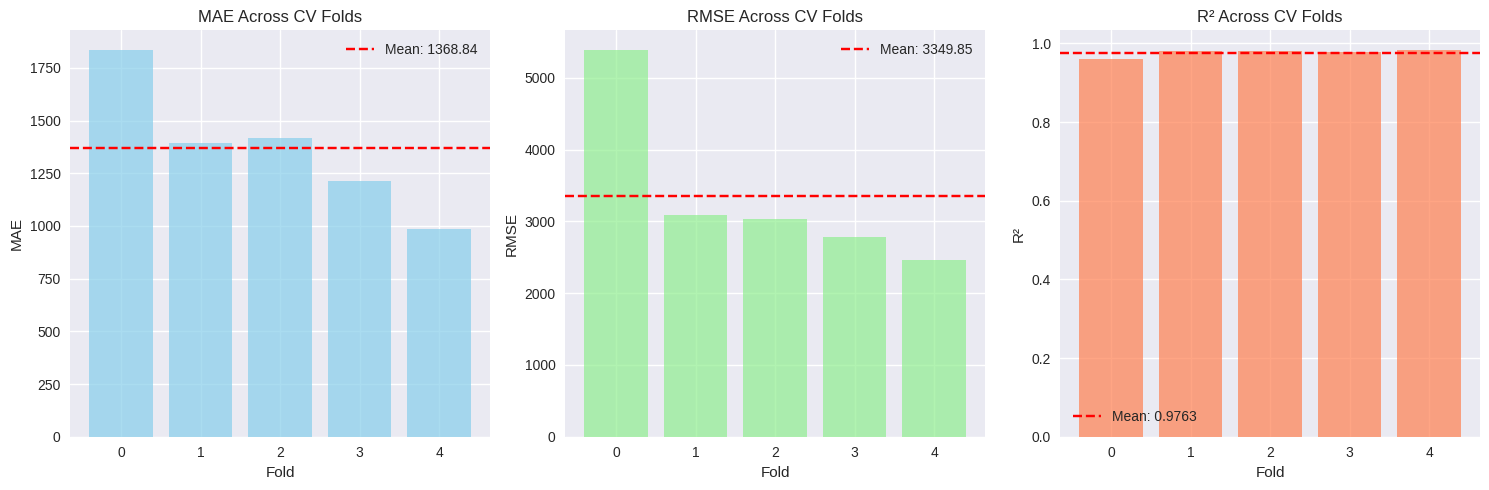

Model doesn't have evals_result_. Train with eval_set to see learning curves.


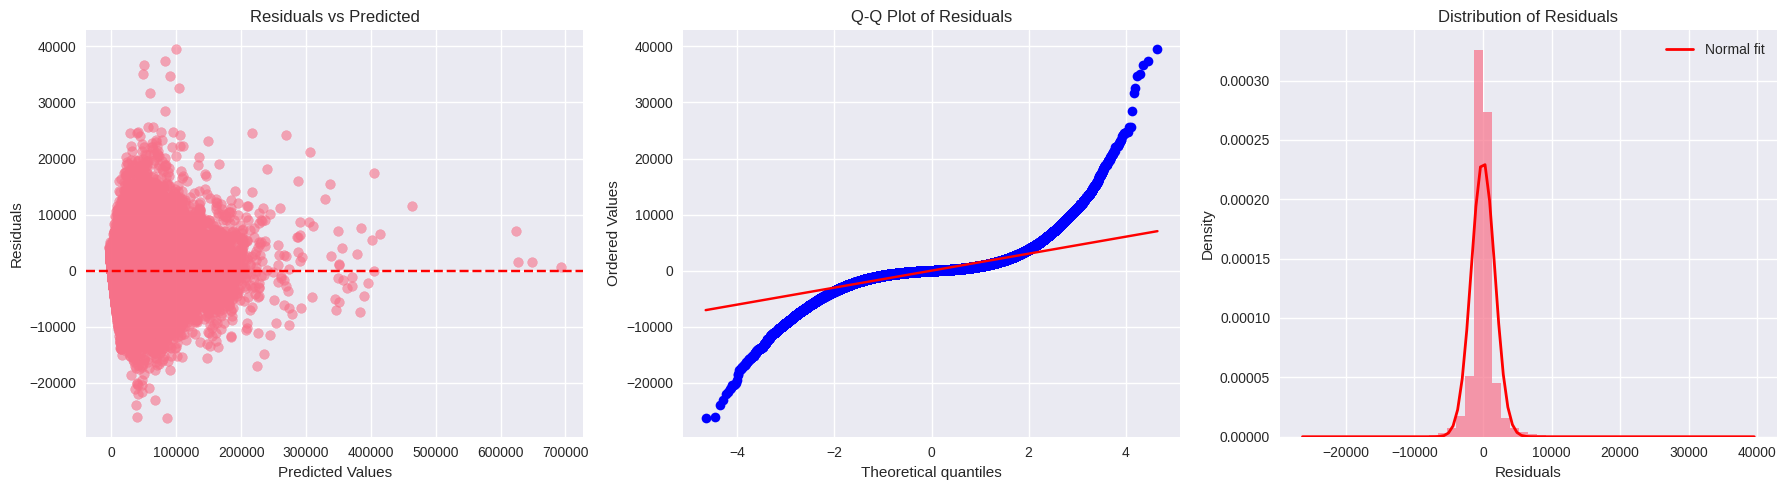

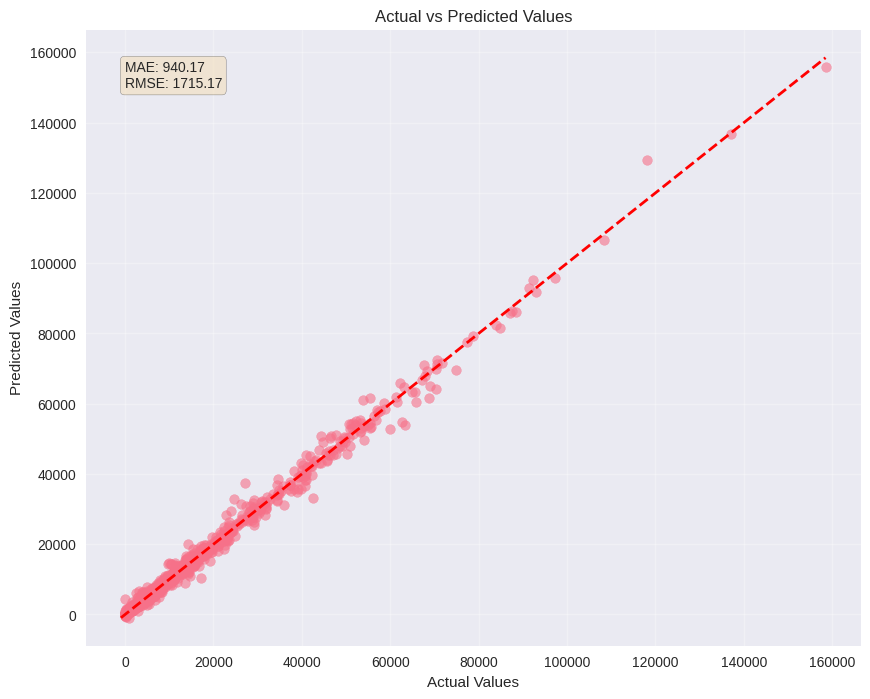

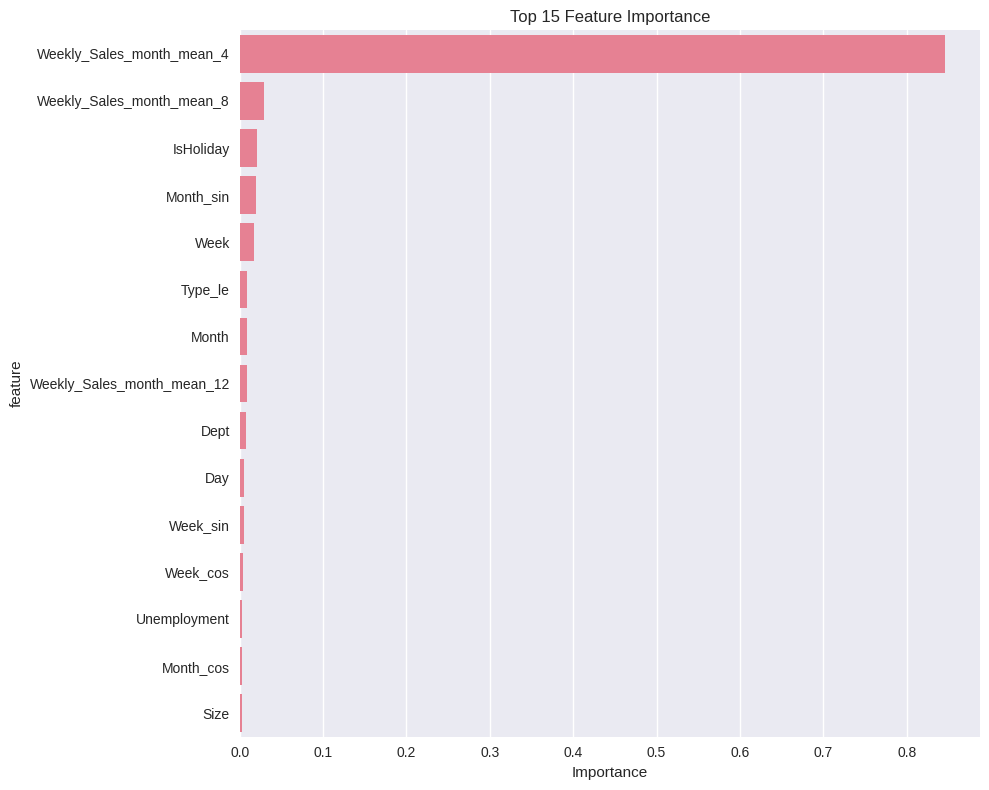

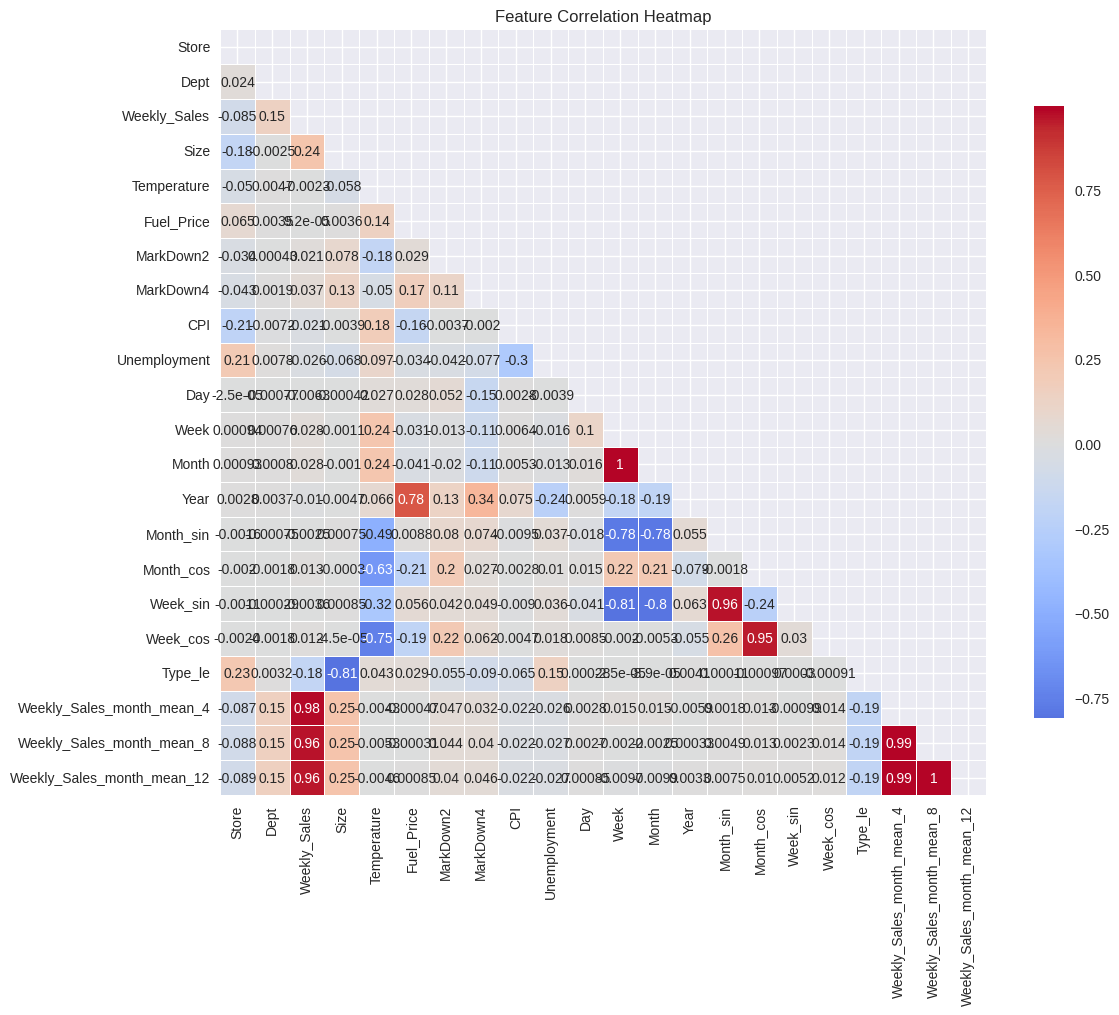

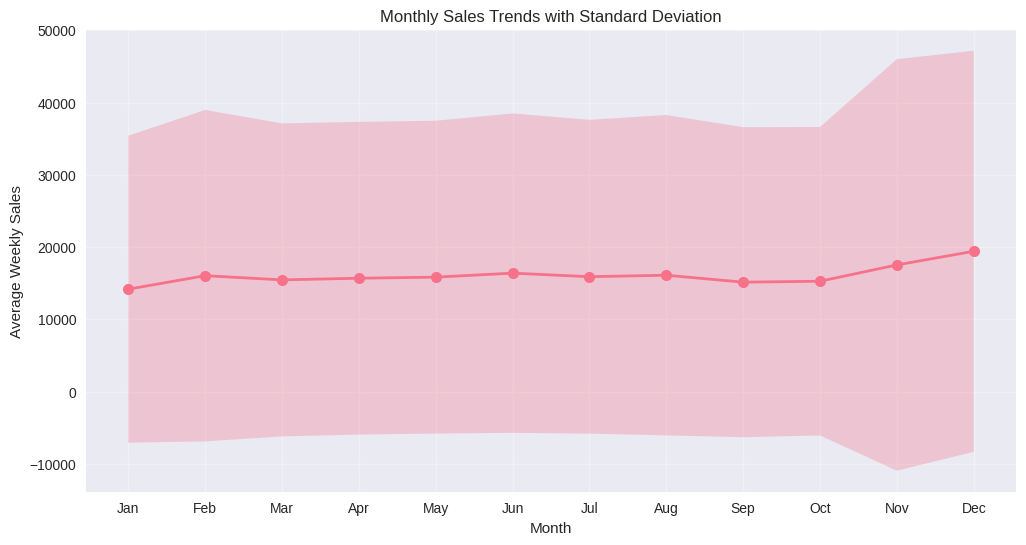

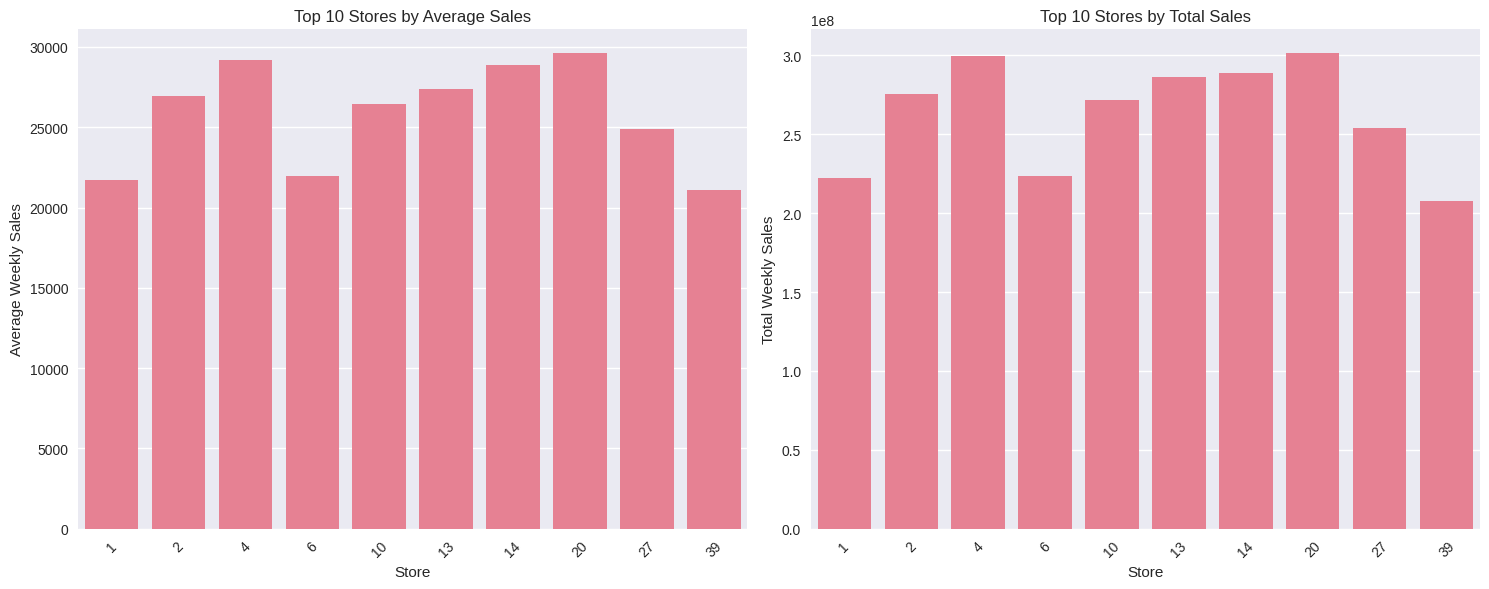

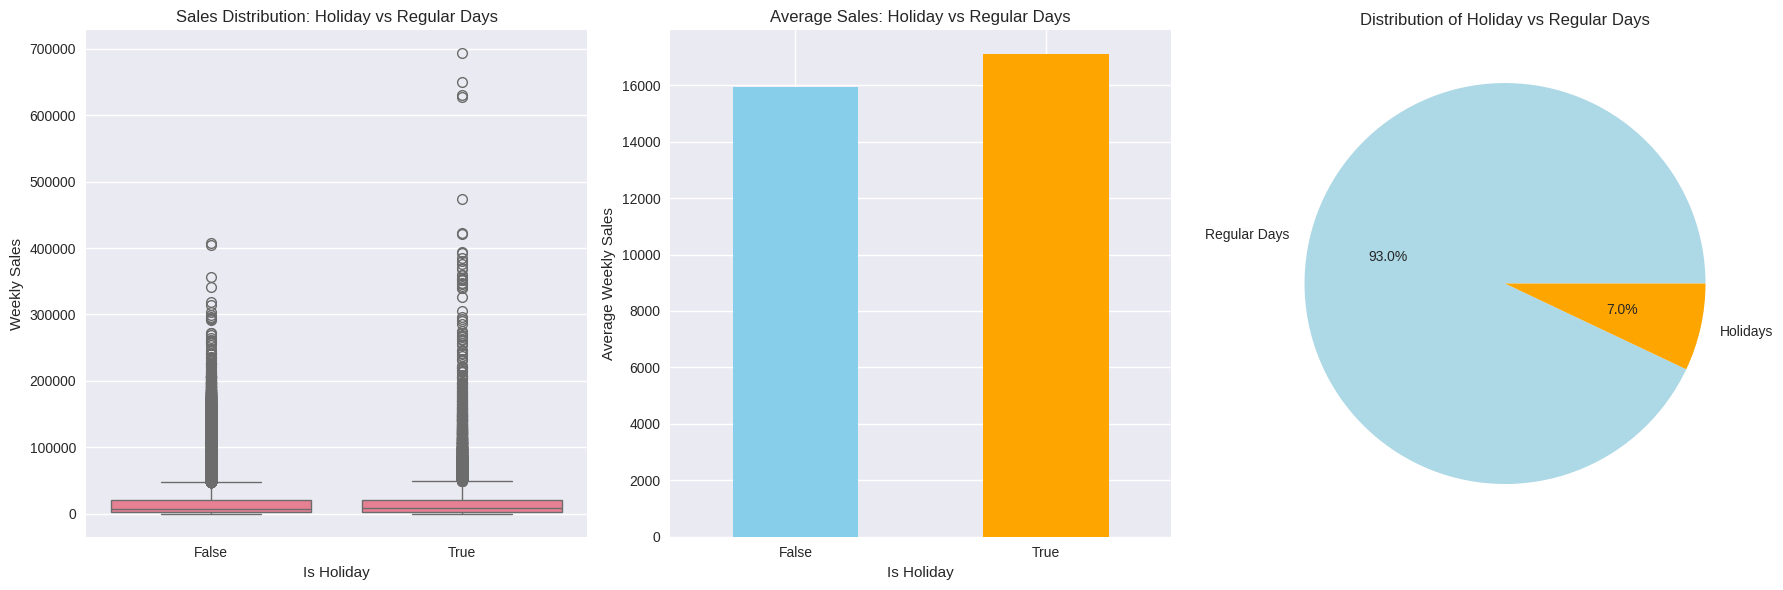

Regular Days Average Sales: $15,949.96
Holiday Average Sales: $17,092.57
Holiday Lift: 7.2%


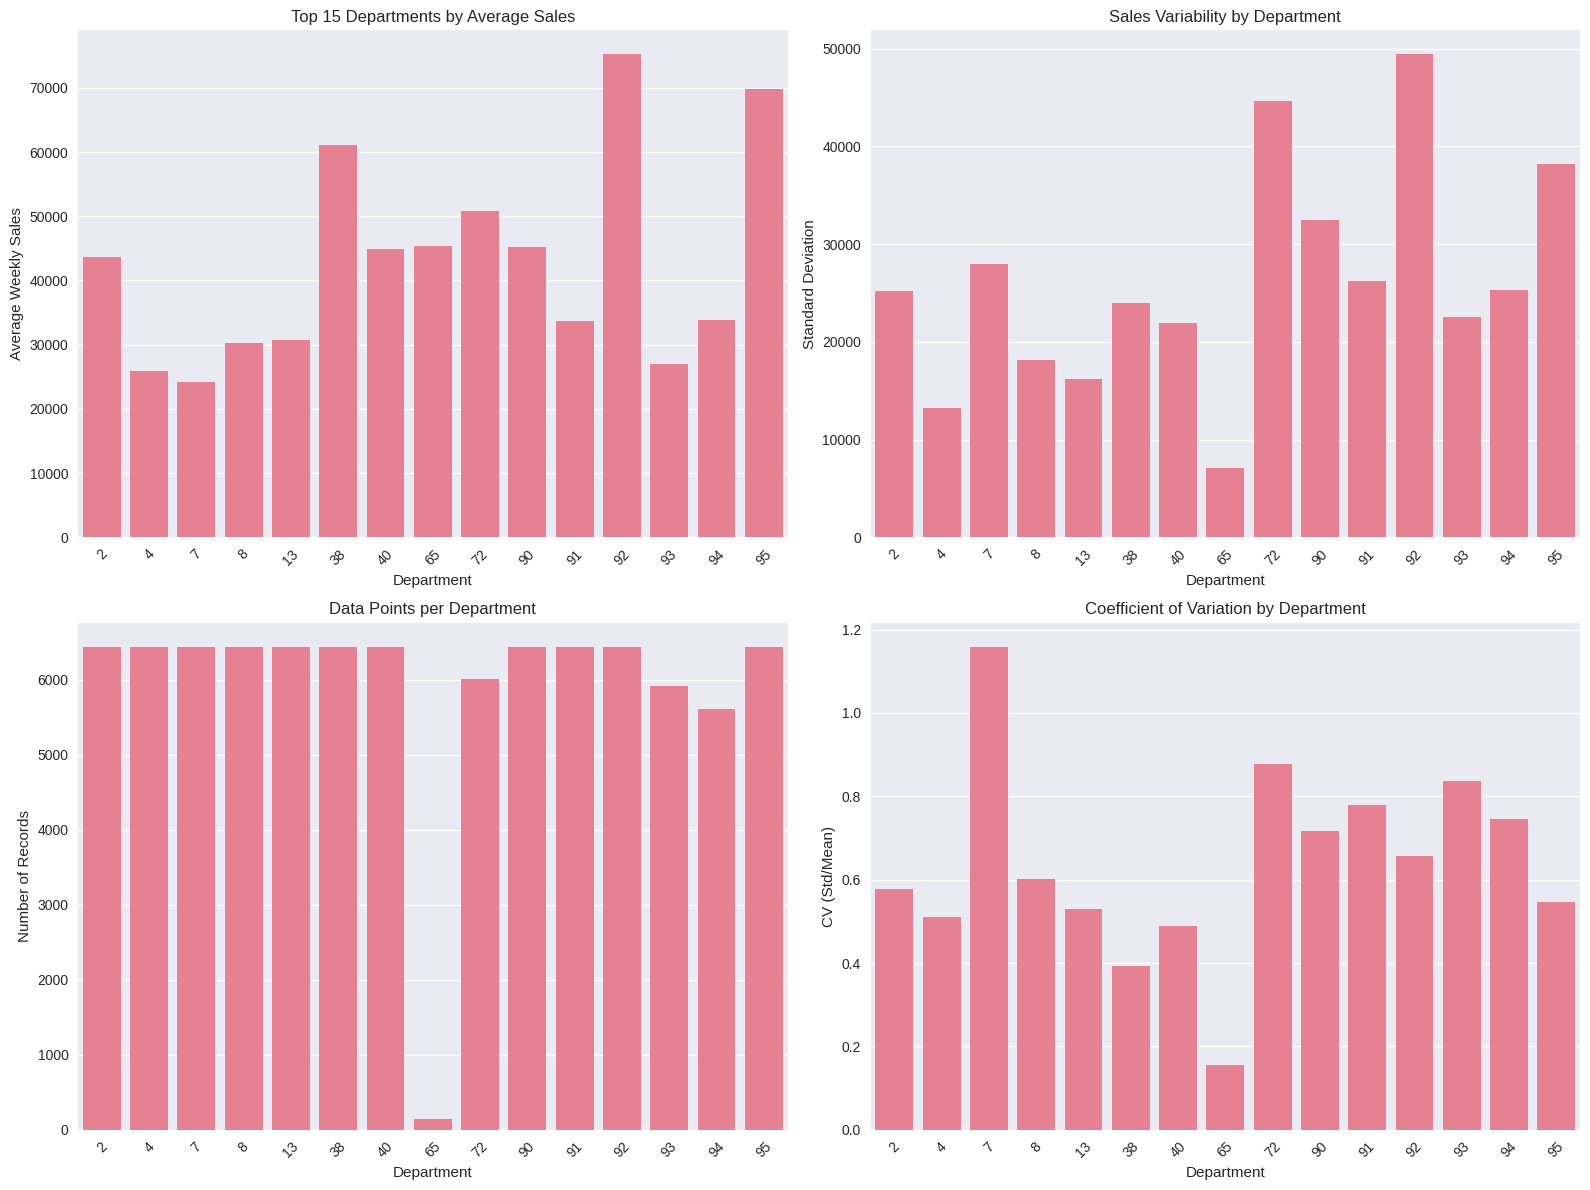

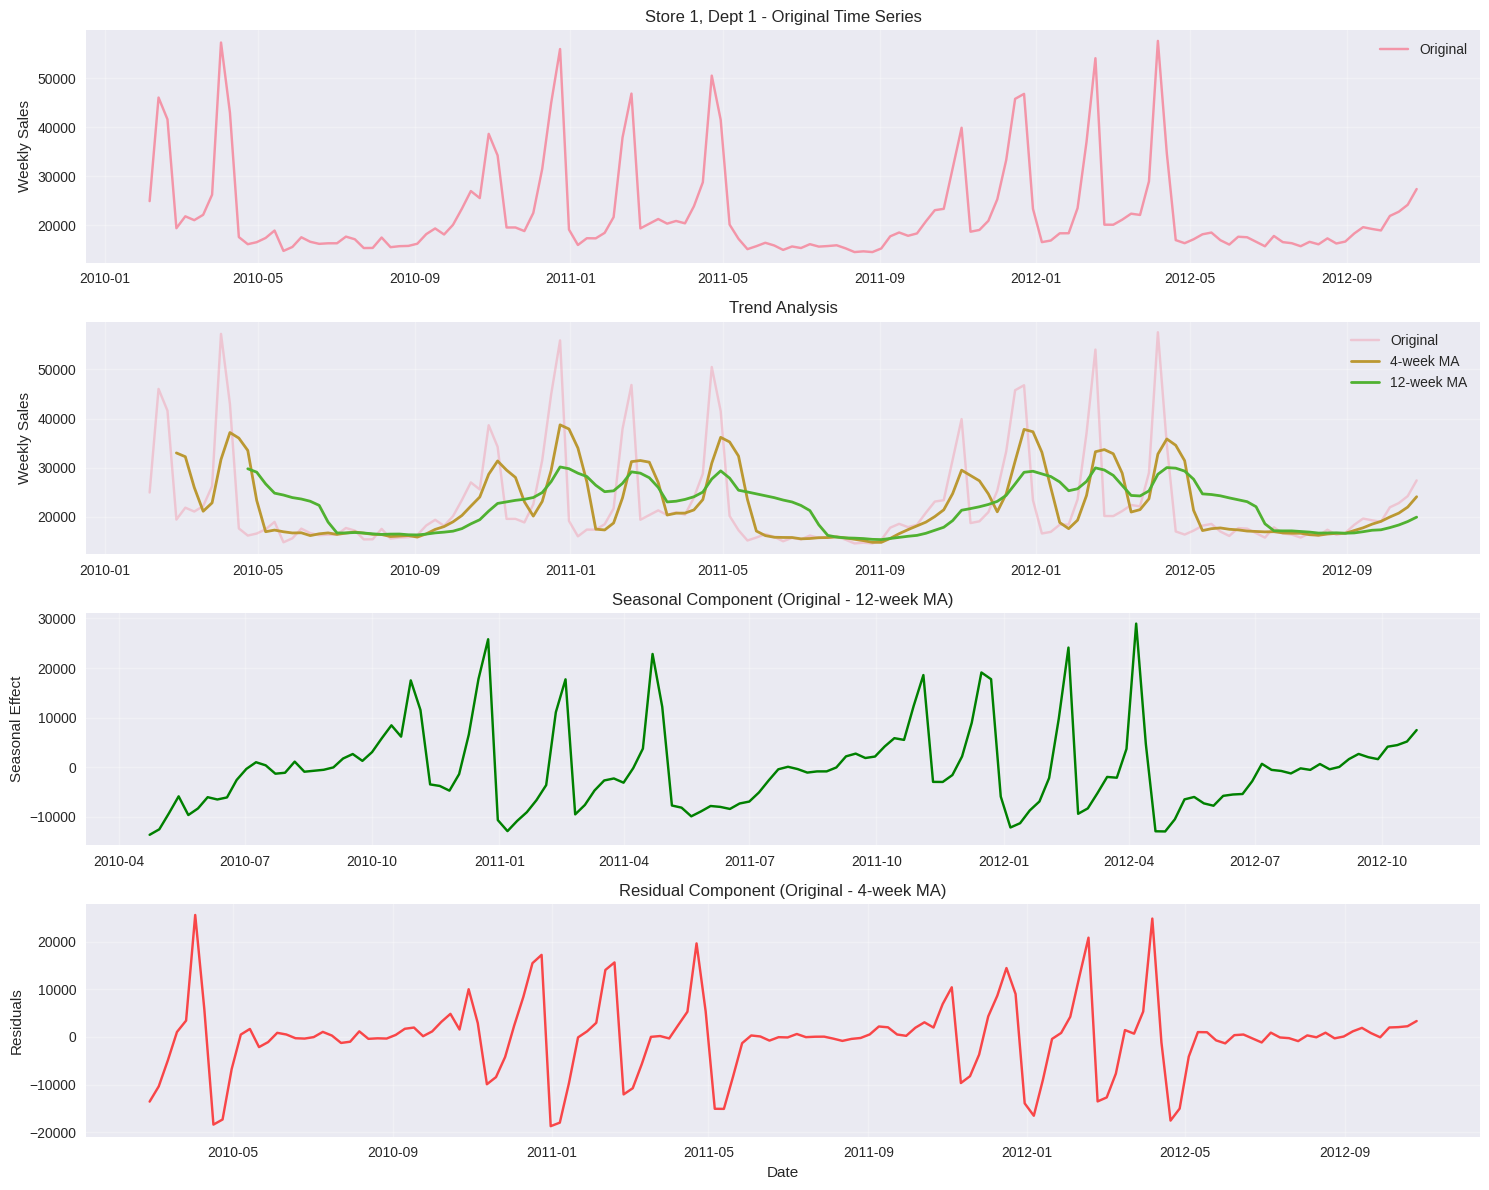

                    XGBOOST MODEL SUMMARY REPORT

📊 MODEL PERFORMANCE METRICS
----------------------------------------
Final Training MAE:  $940.17
Final Training RMSE: $1,715.17
Final Training R²:   0.9943

🔄 CROSS VALIDATION SUMMARY (5-Fold)
----------------------------------------
CV MAE:  $1,368.84 (±280.49)
CV RMSE: $3,349.85 (±1044.97)
CV R²:   0.9763 (±0.0085)

🎯 TOP 10 MOST IMPORTANT FEATURES
----------------------------------------
Weekly_Sales_month_mean_4 0.8455
Weekly_Sales_month_mean_8 0.0295
IsHoliday                 0.0210
Month_sin                 0.0194
Week                      0.0170
Type_le                   0.0093
Month                     0.0090
Weekly_Sales_month_mean_12 0.0083
Dept                      0.0070
Day                       0.0055

⚙️  MODEL CONFIGURATION
----------------------------------------
max_depth            6
learning_rate        0.1
n_estimators         1000
subsample            0.8
colsample_bytree     0.8


In [81]:
# Generate all visualizations
print("🎨 Generating Model Visualizations...")

# 1. Model Performance
plot_cross_validation_results(cv_scores)
plot_learning_curves(model, X_train, y_train)

# 2. Predictions Analysis
y_train_pred = model.predict(X_train)
plot_residuals(y_train, y_train_pred)
plot_actual_vs_predicted(y_train, y_train_pred)

# 3. Feature Analysis
feature_importance_df = plot_feature_importance(model, feature_cols, top_n=15)
correlation_matrix = plot_correlation_heatmap(train_merged)

# 4. Business Insights
plot_monthly_trends(train_merged)
plot_store_performance(train_merged, top_n=10)
plot_holiday_impact(train_merged)
plot_department_analysis(train_merged, top_n=15)

# 5. Time Series Analysis (example for Store 1, Dept 1)
plot_time_series_decomposition(train_merged, store_id=1, dept_id=1)

# 6. Comprehensive Report
create_model_summary_report(model, cv_scores, feature_cols, y_train, y_train_pred)

In [89]:
!pip install shap -q

In [90]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
import seaborn as sns


🔍 Initializing SHAP Analysis...
🚀 Starting Complete SHAP Analysis...
📊 Using 1000 samples for SHAP analysis
🧠 Creating SHAP TreeExplainer...
⚡ Computing SHAP values...

 SHAP Summary Plot (Bee Swarm)


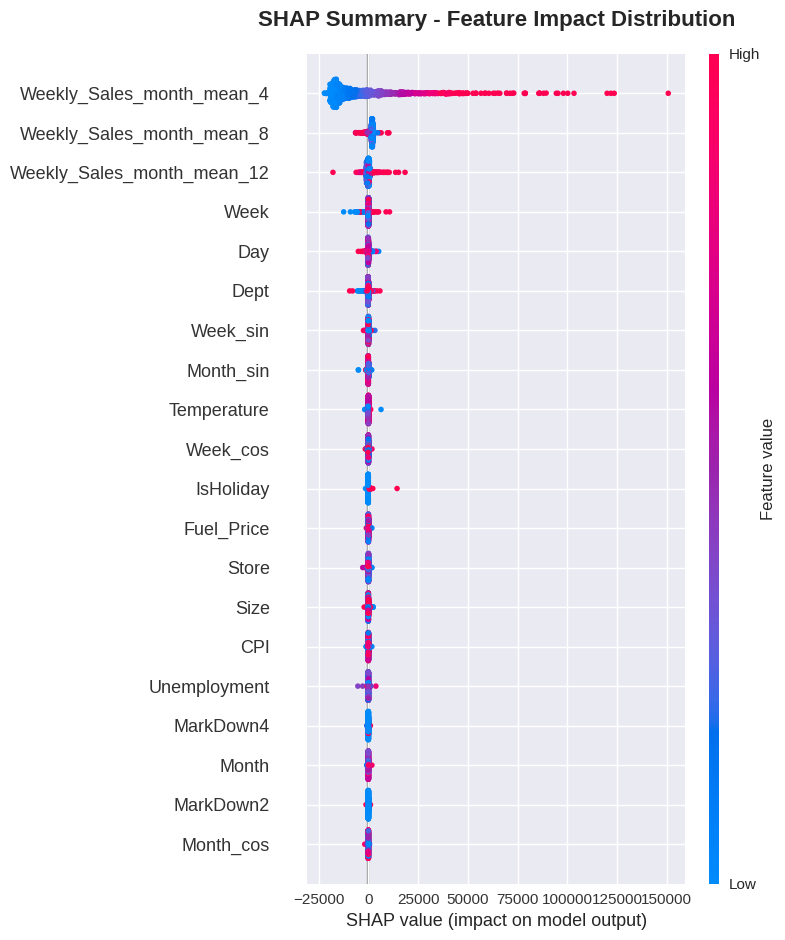


 SHAP Bar Plot (Feature Importance)


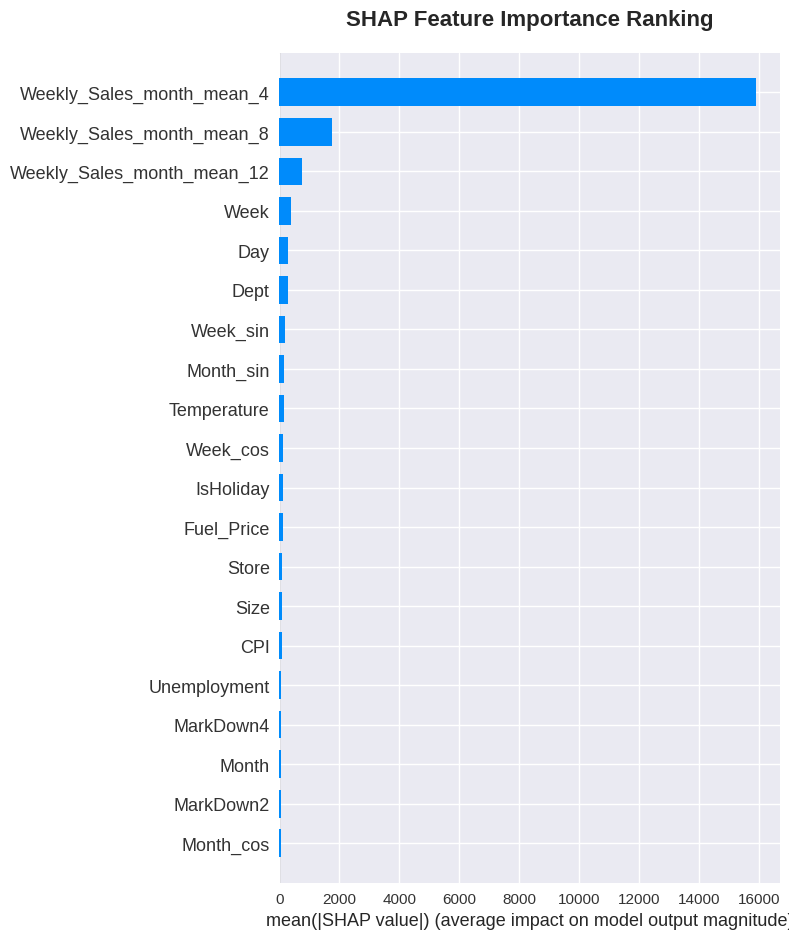


 SHAP Dependence Plots
Creating dependence plots for top 6 features...
  Creating plot 1/6: Weekly_Sales_month_mean_4


<Figure size 1000x600 with 0 Axes>

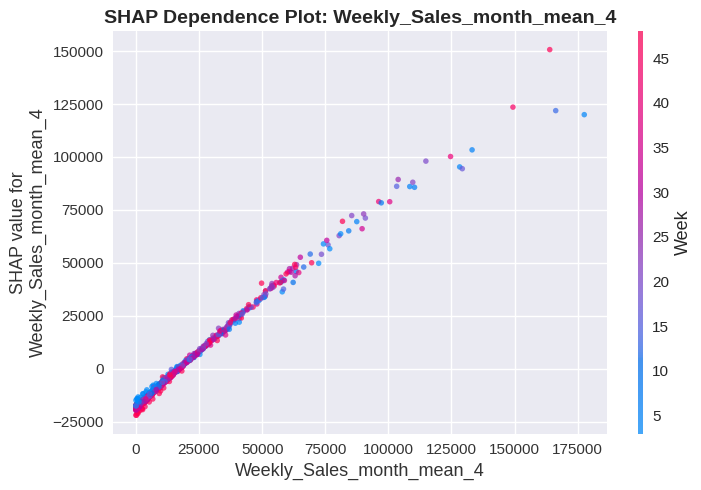

  Creating plot 2/6: Weekly_Sales_month_mean_8


<Figure size 1000x600 with 0 Axes>

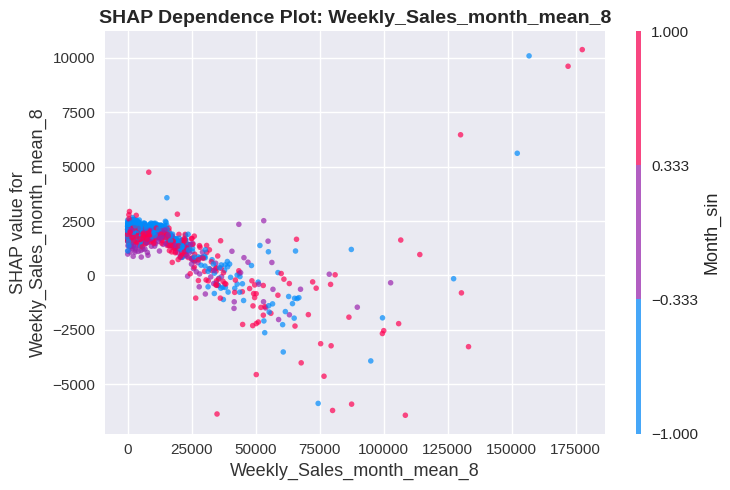

  Creating plot 3/6: Weekly_Sales_month_mean_12


<Figure size 1000x600 with 0 Axes>

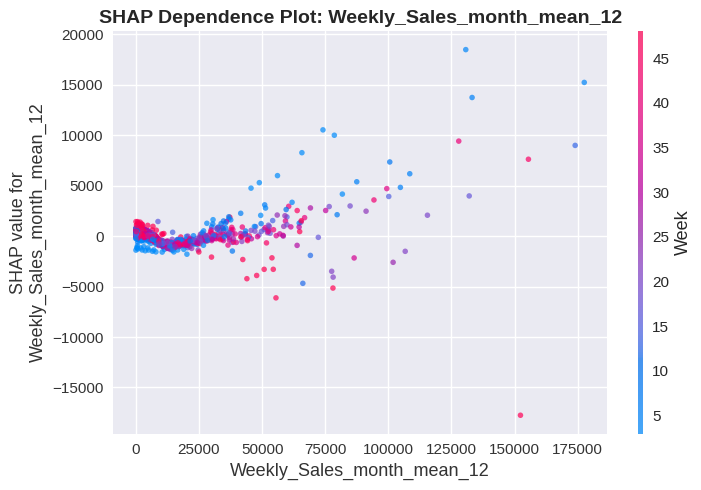

  Creating plot 4/6: Week


<Figure size 1000x600 with 0 Axes>

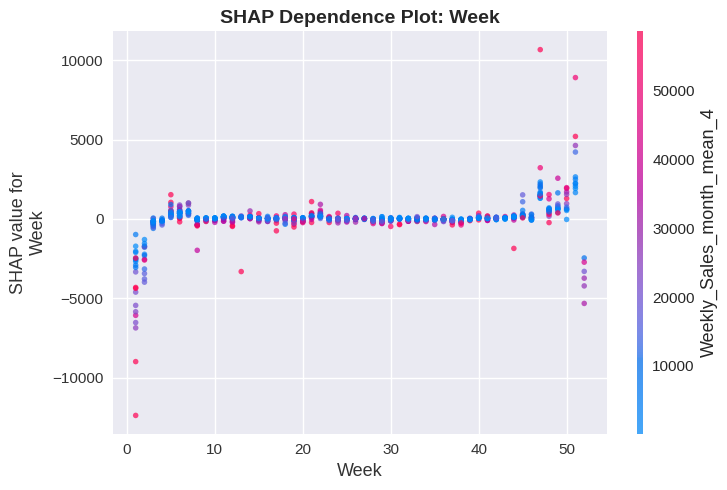

  Creating plot 5/6: Day


<Figure size 1000x600 with 0 Axes>

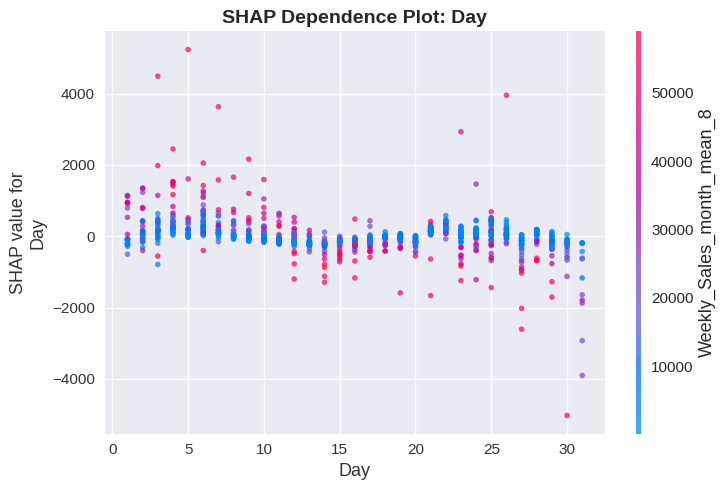

  Creating plot 6/6: Dept


<Figure size 1000x600 with 0 Axes>

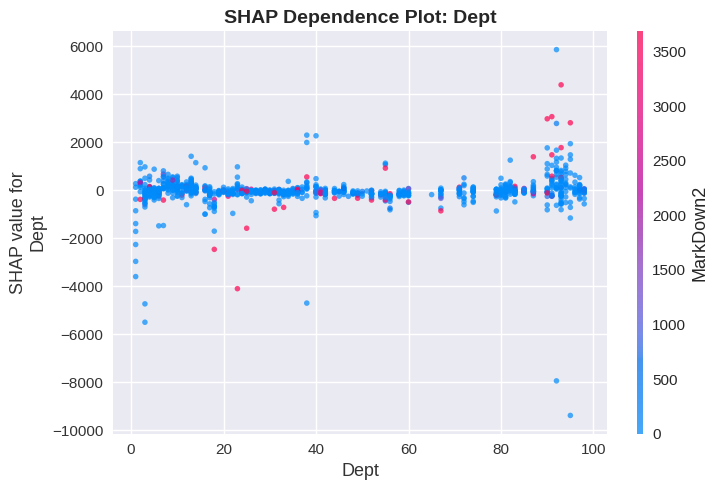


 Custom SHAP Insights


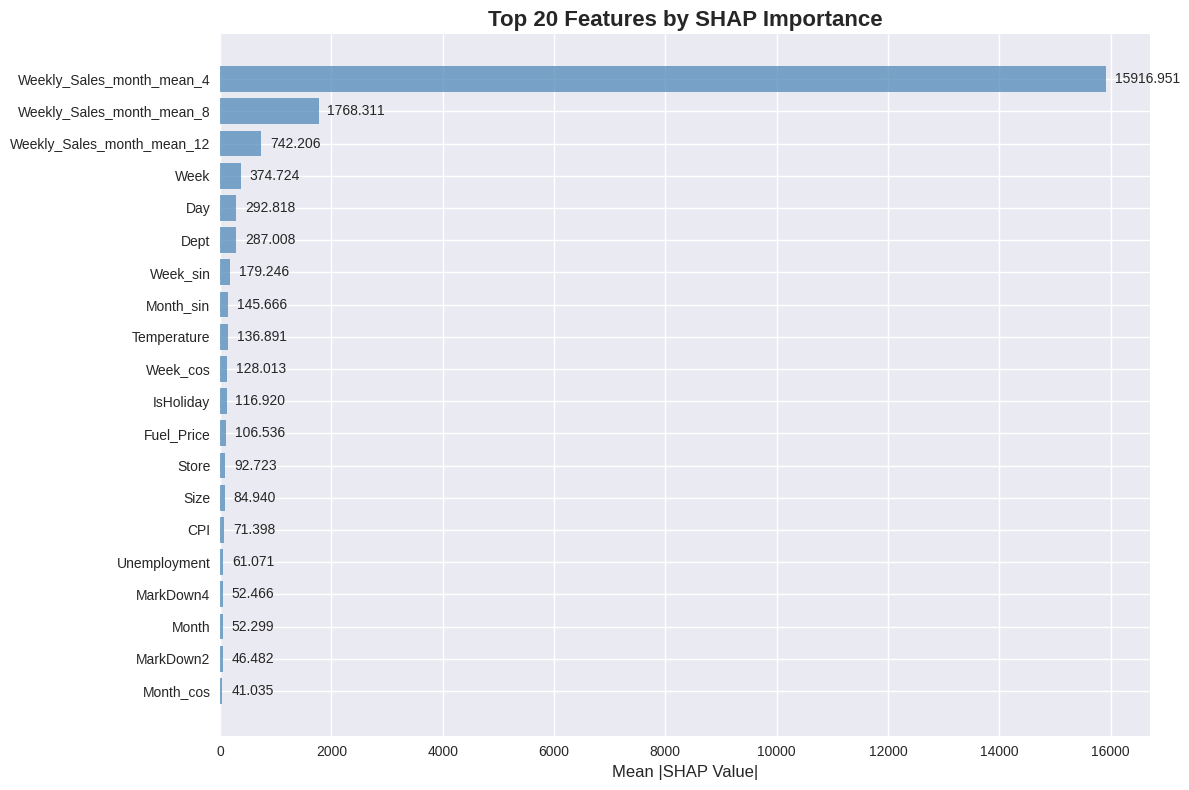


📊 SHAP Feature Impact Analysis:
 1. Weekly_Sales_month_mean_4 | Importance: 15916.9512
    Positive impacts:  297 (avg: +23886.84)
    Negative impacts:  703 (avg: -12549.88)

 2. Weekly_Sales_month_mean_8 | Importance: 1768.3110
    Positive impacts:  892 (avg: +1810.85)
    Negative impacts:  108 (avg: -1416.97)

 3. Weekly_Sales_month_mean_12 | Importance: 742.2062
    Positive impacts:  470 (avg: +830.83)
    Negative impacts:  530 (avg: -663.61)

 4. Week                      | Importance: 374.7240
    Positive impacts:  567 (avg: +317.79)
    Negative impacts:  433 (avg: -449.27)

 5. Day                       | Importance: 292.8184
    Positive impacts:  463 (avg: +330.12)
    Negative impacts:  537 (avg: -260.65)

 6. Dept                      | Importance: 287.0078
    Positive impacts:  393 (avg: +326.62)
    Negative impacts:  607 (avg: -261.36)

 7. Week_sin                  | Importance: 179.2458
    Positive impacts:  574 (avg: +186.45)
    Negative impacts:  426 (avg: -

2025/08/03 08:29:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBoost_SHAP_Analysis at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0/runs/aabc537b3a0441b09dbb8ac573745489.
2025/08/03 08:29:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/kechik21/ML_Final_Project.mlflow/#/experiments/0.



🎉 SHAP Analysis Complete!


In [98]:
# ================================
# SHAP VISUALIZATIONS FOR XGBOOST
# ================================

# Install SHAP if not already installed
!pip install shap -q

import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
import seaborn as sns

# Initialize SHAP with your trained model
print("🔍 Initializing SHAP Analysis...")

def create_shap_analysis(model, X_train, X_test_processed, feature_cols, sample_size=1000):
    """
    Complete SHAP analysis with multiple visualization types
    """

    # Sample data for faster computation
    if len(X_train) > sample_size:
        sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
        X_sample = X_train.iloc[sample_indices]
        print(f"📊 Using {sample_size} samples for SHAP analysis")
    else:
        X_sample = X_train
        print(f"📊 Using all {len(X_train)} samples for SHAP analysis")

    # Create SHAP explainer with interventional feature perturbation
    print("🧠 Creating SHAP TreeExplainer...")
    explainer = shap.TreeExplainer(model, feature_perturbation='interventional')

    # Calculate SHAP values
    print("⚡ Computing SHAP values...")
    shap_values = explainer.shap_values(X_sample, check_additivity=False)

    # Also get some test SHAP values for individual predictions
    test_sample_size = min(100, len(X_test_processed))
    test_sample_indices = np.random.choice(len(X_test_processed), test_sample_size, replace=False)
    X_test_sample = X_test_processed.iloc[test_sample_indices]
    shap_values_test = explainer.shap_values(X_test_sample, check_additivity=False)

    return explainer, shap_values, shap_values_test, X_sample, X_test_sample

def plot_shap_summary(shap_values, X_sample, title="SHAP Summary Plot"):
    """SHAP Summary Plot - shows feature importance and impact"""
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, show=False, max_display=20)
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

def plot_shap_bar(shap_values, X_sample, title="SHAP Feature Importance"):
    """SHAP Bar Plot - shows mean absolute SHAP values"""
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False, max_display=20)
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

def plot_shap_waterfall_examples(explainer, X_test_sample, num_examples=3):
    """SHAP Waterfall plots for individual predictions"""
    for i in range(min(num_examples, len(X_test_sample))):
        plt.figure(figsize=(12, 8))

        # Get SHAP values for this single prediction
        single_shap = explainer.shap_values(X_test_sample.iloc[i:i+1], check_additivity=False)

        # Create waterfall plot
        shap.plots.waterfall(
            shap.Explanation(
                values=single_shap[0],
                base_values=explainer.expected_value,
                data=X_test_sample.iloc[i].values,
                feature_names=X_test_sample.columns.tolist()
            ),
            max_display=15,
            show=False
        )

        plt.title(f'SHAP Waterfall Plot - Test Sample {i+1}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

def plot_shap_dependence_plots(shap_values, X_sample, top_features=6):
    """SHAP Dependence plots for top features"""
    # Get feature importance ranking
    feature_importance = np.abs(shap_values).mean(0)
    top_indices = np.argsort(feature_importance)[-top_features:][::-1]

    print(f"Creating dependence plots for top {top_features} features...")

    for i, feature_idx in enumerate(top_indices):
        if i >= top_features:
            break

        plt.figure(figsize=(10, 6))
        feature_name = X_sample.columns[feature_idx]

        print(f"  Creating plot {i+1}/{top_features}: {feature_name}")

        try:
            # Use feature name instead of index, and let SHAP auto-detect interaction
            shap.dependence_plot(
                feature_name, shap_values, X_sample,
                interaction_index='auto',
                show=False,
                alpha=0.7
            )
            plt.title(f'SHAP Dependence Plot: {feature_name}', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"    Error creating plot for {feature_name}: {str(e)}")
            # Fallback to simple scatter plot
            plt.scatter(X_sample.iloc[:, feature_idx], shap_values[:, feature_idx], alpha=0.6)
            plt.xlabel(f'{feature_name} (Feature Value)')
            plt.ylabel(f'SHAP Value for {feature_name}')
            plt.title(f'SHAP Dependence: {feature_name}', fontsize=14, fontweight='bold')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

def plot_shap_force_plots(explainer, X_test_sample, num_examples=2):
    """SHAP Force plots for individual predictions"""
    print("🎯 Creating SHAP Force Plots...")

    for i in range(min(num_examples, len(X_test_sample))):
        # Get SHAP values for single prediction
        single_shap = explainer.shap_values(X_test_sample.iloc[i:i+1], check_additivity=False)

        print(f"\n📈 Force Plot for Test Sample {i+1}:")
        print(f"   Store: {X_test_sample.iloc[i]['Store'] if 'Store' in X_test_sample.columns else 'N/A'}")
        print(f"   Dept: {X_test_sample.iloc[i]['Dept'] if 'Dept' in X_test_sample.columns else 'N/A'}")

        # Create force plot
        shap.force_plot(
            explainer.expected_value,
            single_shap[0],
            X_test_sample.iloc[i],
            matplotlib=True,
            show=False,
            figsize=(16, 4)
        )
        plt.title(f'SHAP Force Plot - Test Sample {i+1}', fontsize=14, fontweight='bold', pad=20)
        plt.show()

def create_custom_shap_insights(shap_values, X_sample, feature_cols):
    """Create custom insights from SHAP values"""

    # Calculate feature importance
    feature_importance = np.abs(shap_values).mean(0)
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    # Plot custom feature importance
    plt.figure(figsize=(12, 8))
    top_20 = importance_df.head(20)

    bars = plt.barh(range(len(top_20)), top_20['importance'],
                   color='steelblue', alpha=0.7)
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.xlabel('Mean |SHAP Value|', fontsize=12)
    plt.title('Top 20 Features by SHAP Importance', fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()

    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + max(top_20['importance']) * 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Feature impact analysis
    print("\n📊 SHAP Feature Impact Analysis:")
    print("="*50)

    for i, (feature, importance) in enumerate(importance_df.head(10).values):
        feature_shap = shap_values[:, feature_cols.index(feature)]
        positive_impact = np.sum(feature_shap > 0)
        negative_impact = np.sum(feature_shap < 0)
        avg_positive = np.mean(feature_shap[feature_shap > 0]) if positive_impact > 0 else 0
        avg_negative = np.mean(feature_shap[feature_shap < 0]) if negative_impact > 0 else 0

        print(f"{i+1:2d}. {feature:<25} | Importance: {importance:.4f}")
        print(f"    Positive impacts: {positive_impact:4d} (avg: {avg_positive:+.2f})")
        print(f"    Negative impacts: {negative_impact:4d} (avg: {avg_negative:+.2f})")
        print()

def run_complete_shap_analysis():
    """Run the complete SHAP analysis pipeline"""

    print("🚀 Starting Complete SHAP Analysis...")
    print("="*60)

    # Create SHAP analysis
    explainer, shap_values, shap_values_test, X_sample, X_test_sample = create_shap_analysis(
        model, X_train, X_test_processed, feature_cols, sample_size=1000
    )

    print("\n SHAP Summary Plot (Bee Swarm)")
    plot_shap_summary(shap_values, X_sample, "SHAP Summary - Feature Impact Distribution")

    print("\n SHAP Bar Plot (Feature Importance)")
    plot_shap_bar(shap_values, X_sample, "SHAP Feature Importance Ranking")

    print("\n SHAP Dependence Plots")
    plot_shap_dependence_plots(shap_values, X_sample, top_features=6)

    #print("\n4️⃣ SHAP Waterfall Plots (Individual Predictions)")
    #plot_shap_waterfall_examples(explainer, X_test_sample, num_examples=3)

    #print("\n5️⃣ SHAP Force Plots")
    #plot_shap_force_plots(explainer, X_test_sample, num_examples=2)

    print("\n Custom SHAP Insights")
    create_custom_shap_insights(shap_values, X_sample, feature_cols)

    # Log to MLflow
    with mlflow.start_run(run_name="XGBoost_SHAP_Analysis") as run:
        mlflow.log_param("shap_sample_size", len(X_sample))
        mlflow.log_param("shap_test_samples", len(X_test_sample))
        mlflow.log_param("shap_analysis_features", len(feature_cols))

        # Log top features by SHAP importance
        feature_importance = np.abs(shap_values).mean(0)
        top_features = [feature_cols[i] for i in np.argsort(feature_importance)[-10:][::-1]]
        mlflow.log_param("top_10_shap_features", top_features)

        print(f"\n✅ SHAP analysis logged to MLflow run: {run.info.run_id}")

    print("\n🎉 SHAP Analysis Complete!")
    print("="*60)

    return explainer, shap_values, X_sample

# Execute the complete SHAP analysis
explainer, shap_values, X_sample = run_complete_shap_analysis()